## Migrating from Spark to BigQuery via Dataproc -- Part 2

* [Part 1](01_spark.ipynb): The original Spark code, now running on Dataproc (lift-and-shift).
* [Part 2](02_gcs.ipynb): Replace HDFS by Google Cloud Storage. This enables job-specific-clusters. (cloud-native)
* [Part 3](03_automate.ipynb): Automate everything, so that we can run in a job-specific cluster. (cloud-optimized)
* [Part 4](04_bigquery.ipynb): Load CSV into BigQuery, use BigQuery. (modernize)
* [Part 5](05_functions.ipynb): Using Cloud Functions, launch analysis every time there is a new file in the bucket. (serverless)


### Catch up: get data

In [1]:
# Catch up cell. Run if you did not do previous notebooks of this sequence
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! kaggle datasets download vijayuv/onlineretail
! unzip onlineretail.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=a18b9cd8113d25af4ea45352b5dc2dd6cc66ac15a5fb6faa4c771415bd7b93f8
  Stored in directory: /root/.cache/pip/wheels/03/f3/c7/fc5a63bb33d22177609b06c5b4c714b5eb3f1b195ce9dc5e47
Successfully built kaggle
  0%|                                               | 0.00/7.20M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 7.20M/7.20M [00:00<00:00, 84.9MB/s]
Archive:  onlineretail.zip
  inflating: OnlineRetail.csv        


### Copy data to GCS

Instead of having the data in HDFS, keep the data in GCS. This will allow us to delete the cluster once we are done ("job-specific clusters")

In [3]:
BUCKET='cloud-training-demos-purchase'  # CHANGE
!gsutil cp OnlineRetail* gs://$BUCKET/

Copying file://OnlineRetail.csv [Content-Type=text/csv]...
- [1 files][ 43.5 MiB/ 43.5 MiB]                                                
Operation completed over 1 objects/43.5 MiB.                                     


In [4]:
!gsutil ls gs://$BUCKET/OnlineRetail*

gs://cloud-training-demos-purchase/OnlineRetail.csv


### Reading in data

Change any ```hdfs://``` URLs to ```gs://``` URLs. The code remains the same.

In [5]:
from pyspark.sql import SparkSession, SQLContext, Row

spark = SparkSession.builder.appName("kdd").getOrCreate()
sc = spark.sparkContext
header=spark.sparkContext.textFile("gs://{}/OnlineRetail.csv".format(BUCKET)).first()
data_file = "gs://{}/OnlineRetail.csv".format(BUCKET)
raw_rdd = sc.textFile(data_file).filter(lambda l :not str(l).startswith(header)).cache()
raw_rdd.take(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/12/05 17:02:21 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/12/05 17:02:21 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/12/05 17:02:21 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/12/05 17:02:21 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


['536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom',
 '536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom',
 '536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom',
 '536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom',
 '536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom']

In [6]:
csv_rdd = raw_rdd.map(lambda row: row.split(","))
parsed_rdd = csv_rdd.map(lambda r: Row(
    invoiceNo=r[0], 
    stockcode=r[1],
    description=r[2],
    quantity=r[3],
    invoicedate=r[4],
    unitprice=r[5],
    customerid=r[6],
    country=r[7]
    )
)
parsed_rdd.take(5)

[Row(invoiceNo='536365', stockcode='85123A', description='WHITE HANGING HEART T-LIGHT HOLDER', quantity='6', invoicedate='12/1/2010 8:26', unitprice='2.55', customerid='17850', country='United Kingdom'),
 Row(invoiceNo='536365', stockcode='71053', description='WHITE METAL LANTERN', quantity='6', invoicedate='12/1/2010 8:26', unitprice='3.39', customerid='17850', country='United Kingdom'),
 Row(invoiceNo='536365', stockcode='84406B', description='CREAM CUPID HEARTS COAT HANGER', quantity='8', invoicedate='12/1/2010 8:26', unitprice='2.75', customerid='17850', country='United Kingdom'),
 Row(invoiceNo='536365', stockcode='84029G', description='KNITTED UNION FLAG HOT WATER BOTTLE', quantity='6', invoicedate='12/1/2010 8:26', unitprice='3.39', customerid='17850', country='United Kingdom'),
 Row(invoiceNo='536365', stockcode='84029E', description='RED WOOLLY HOTTIE WHITE HEART.', quantity='6', invoicedate='12/1/2010 8:26', unitprice='3.39', customerid='17850', country='United Kingdom')]

In [8]:
import pyspark.sql.functions as F

sqlContext = SQLContext(sc)
df = sqlContext.createDataFrame(parsed_rdd)
df_clean = df.withColumn("customerid", df.customerid.cast('int'))
df_clean = df.withColumn("quantity", df.customerid.cast('int'))
df_clean = df.withColumn("unitprice", df.customerid.cast('float'))
df_clean = df_clean.filter(F.col('customerid').isNotNull())
df_clean = df_clean.filter(F.col('quantity').isNotNull())
df_clean = df_clean.filter(F.col('unitprice').isNotNull())
df_clean.show()

df_user = df_clean.groupBy('customerid').count().orderBy('count', ascending=False)
df_user.show()
df_user.printSchema()

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|invoiceNo|stockcode|         description|quantity|   invoicedate|unitprice|customerid|       country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|  17850.0|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|  17850.0|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|  17850.0|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|  17850.0|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|  17850.0|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/2010 8:26|  17850.0|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|12/1/2010 8:26|  17850

+----------+-----+
|customerid|count|
+----------+-----+
|     17841| 7931|
|     14911| 5863|
|     14096| 5044|
|     12748| 4609|
|     14606| 2721|
|     15311| 2467|
|     14646| 2071|
|     13089| 1832|
|     13263| 1641|
|     14298| 1604|
|     15039| 1505|
|     14156| 1412|
|     18118| 1270|
|     14159| 1207|
|     14796| 1147|
|     15005| 1140|
|     16033| 1134|
|     14056| 1126|
|     14769| 1087|
|     17511| 1073|
+----------+-----+
only showing top 20 rows

root
 |-- customerid: string (nullable = true)
 |-- count: long (nullable = false)



In [9]:
df_clean.registerTempTable("purchases")
attack_stats = sqlContext.sql("""
                           SELECT 
                             customerid,
                             SUM(unitprice * quantity) as totalspent 
                           FROM purchases
                           GROUP BY customerid
                           ORDER BY totalspent DESC
                           """)
attack_stats.show()



+----------+-------------+
|customerid|   totalspent|
+----------+-------------+
|     14646|2.862165258E9|
|     17450| 1.20455605E9|
|     18102|1.160736444E9|
|     14911|1.141750181E9|
|     17511|1.098359964E9|
|     12415|  9.3512263E8|
|     13694| 8.42715066E8|
|     14298| 8.14228206E8|
|     14156| 8.01059728E8|
|     16684| 7.93858088E8|
|     15311| 5.76642882E8|
|     17404|  5.5797224E8|
|     16422| 5.35225824E8|
|     16333| 5.25661272E8|
|     16029| 5.15300292E8|
|     17949| 4.94871879E8|
|     17381| 4.45753126E8|
|     15769|  4.3617054E8|
|     15061| 4.28244474E8|
|     17841| 4.04598198E8|
+----------+-------------+
only showing top 20 rows



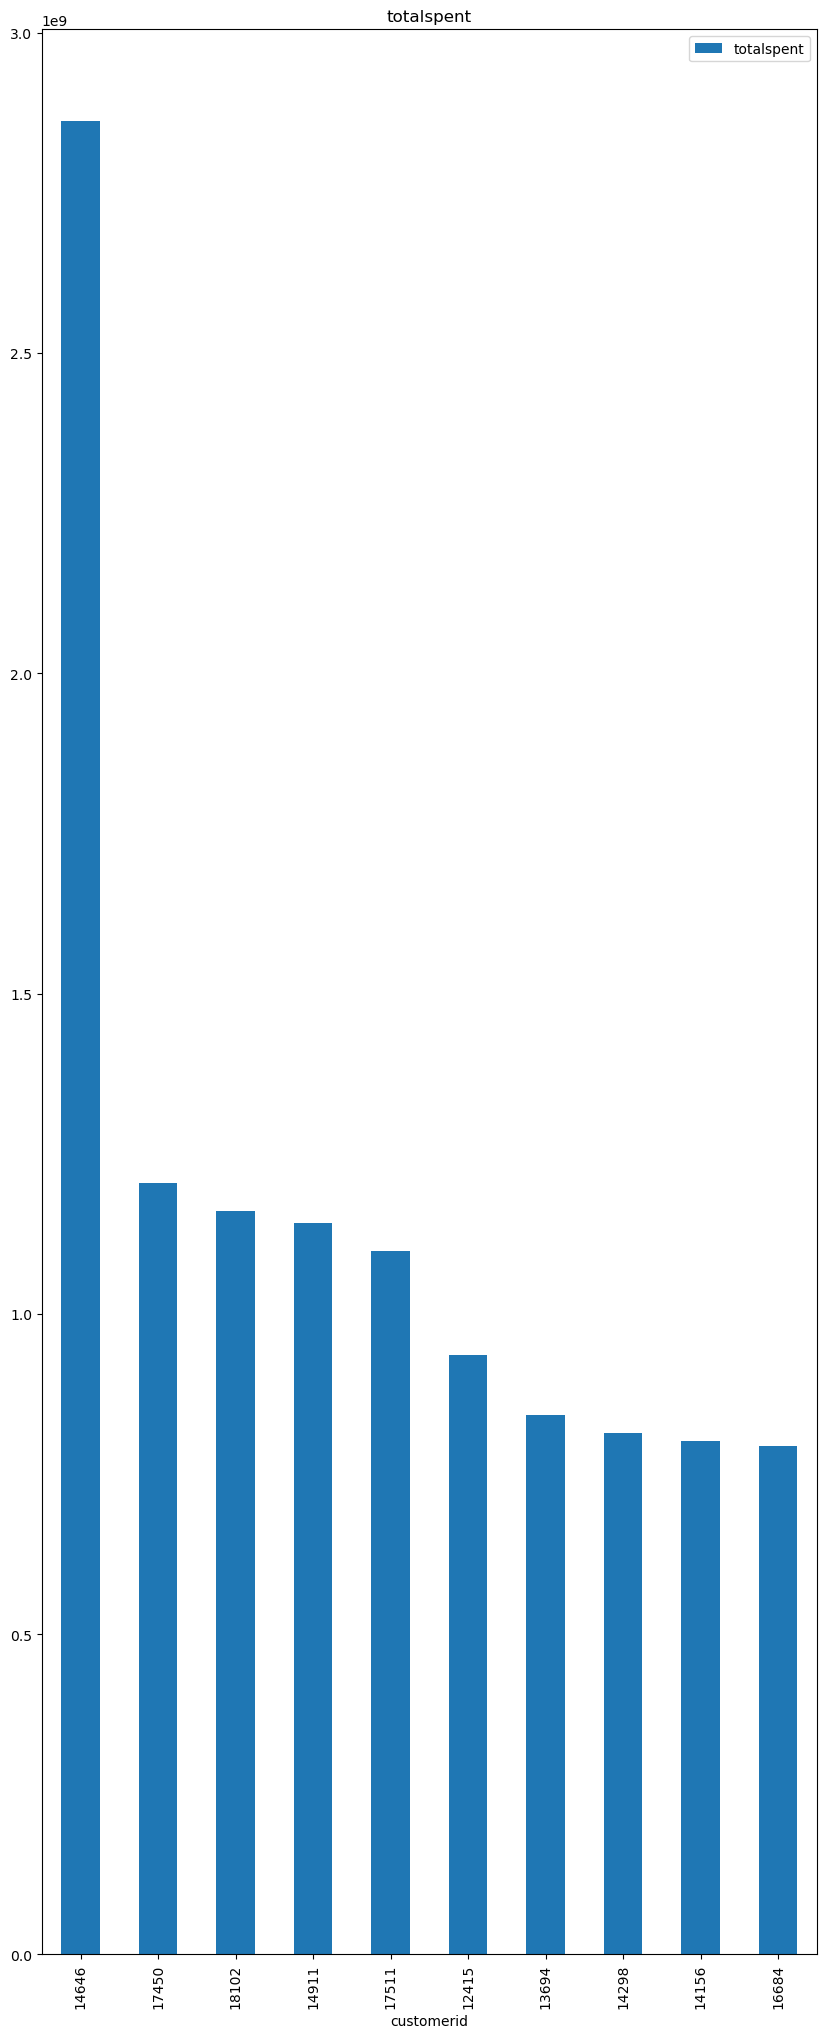

In [10]:
%matplotlib inline
df_plot = attack_stats.limit(10)
ax = df_plot.toPandas().plot.bar(x='customerid', subplots=True, figsize=(10,25))

### Write out report

Make sure to copy the output to GCS so that we can safely delete the cluster.

In [11]:
ax[0].get_figure().savefig('report.png');
!gsutil rm -rf gs://$BUCKET/sparktobq/
!gsutil cp report.png gs://$BUCKET/sparktobq/

CommandException: 1 files/objects could not be removed.
Copying file://report.png [Content-Type=image/png]...
/ [1 files][ 32.2 KiB/ 32.2 KiB]                                                
Operation completed over 1 objects/32.2 KiB.                                     


In [12]:
df_user.write.format("csv").mode("overwrite").save("gs://{}/sparktobq/purchases".format(BUCKET))

In [13]:
!gsutil ls gs://$BUCKET/sparktobq/**

gs://cloud-training-demos-purchase/sparktobq/purchases/
gs://cloud-training-demos-purchase/sparktobq/purchases/_SUCCESS
gs://cloud-training-demos-purchase/sparktobq/purchases/part-00000-c627d438-a97d-4a70-9ae0-1efd78a9a199-c000.csv
gs://cloud-training-demos-purchase/sparktobq/purchases/part-00001-c627d438-a97d-4a70-9ae0-1efd78a9a199-c000.csv
gs://cloud-training-demos-purchase/sparktobq/purchases/part-00002-c627d438-a97d-4a70-9ae0-1efd78a9a199-c000.csv
gs://cloud-training-demos-purchase/sparktobq/report.png


Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.